In [72]:
!pip install kagglehub
!pip install keras
!pip install scikit-learn
!pip install matplotlib seaborn

In [73]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras import layers, models, optimizers, regularizers
from keras.applications import MobileNetV2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import image_dataset_from_directory
from keras.preprocessing import image
from keras.models import load_model

from sklearn.metrics import classification_report, confusion_matrix

In [74]:
import kagglehub

dataset_path = kagglehub.dataset_download("yasserhessein/the-vertebrae-xray-images")
print(f"Caminho do dataset: {dataset_path}")

Caminho do dataset: /kaggle/input/the-vertebrae-xray-images


In [75]:
data_dir = os.path.join(dataset_path, "xkt857dsxk-1", "224", "224")

img_size = (224, 224)
batch_size = 32
seed = 42

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes:", class_names)

# Performance otimizada (prefetch)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 338 files belonging to 3 classes.
Using 271 files for training.
Found 338 files belonging to 3 classes.
Using 67 files for validation.
Classes: ['Normal', 'Scol', 'Spond']


In [76]:
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
])

In [77]:
base_model = MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

inputs = layers.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(3, activation='softmax')(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,619,203 (9.99 MB)

 Trainable params: 361,219 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [78]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-7),
    ModelCheckpoint('melhor_modelo.keras', monitor='val_loss', save_best_only=True)
]


In [79]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_fase2 = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.4085 - loss: 1.8727 - val_accuracy: 0.5821 - val_loss: 1.4157 - learning_rate: 1.0000e-04
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5475 - loss: 1.6114 - val_accuracy: 0.6866 - val_loss: 1.3088 - learning_rate: 1.0000e-04
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5794 - loss: 1.4940 - val_accuracy: 0.7761 - val_loss: 1.2360 - learning_rate: 1.0000e-04
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6617 - loss: 1.4253 - val_accuracy: 0.7761 - val_loss: 1.1768 - learning_rate: 1.0000e-04
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7045 - loss: 1.3126 - val_accuracy: 0.8209 - val_loss: 1.1282 - learning_rate: 1.0000e-04
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7305 - loss: 1.2016 - val_accuracy: 0.8507 - val_loss: 1.0942 - learning_rate: 1.0000e-04
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.7377 - loss: 1.1807 - val_

In [80]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
              precision    recall  f1-score   support

      Normal       1.00      0.54      0.70        13
        Scol       0.88      0.95      0.91        37
       Spond       0.85      1.00      0.92        17

    accuracy                           0.88        67
   macro avg       0.91      0.83      0.84        67
weighted avg       0.89      0.88      0.87        67



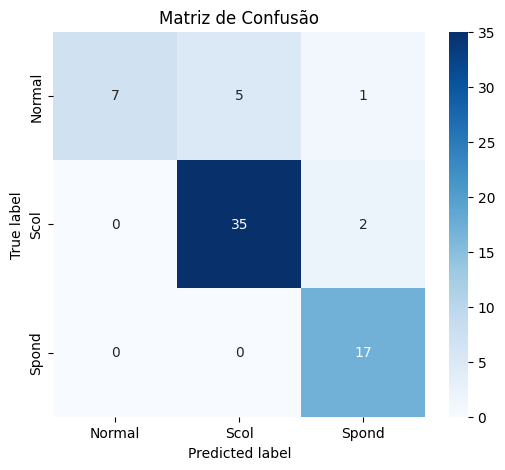

In [81]:
# Gera previsões
y_pred = []
y_true = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    # Directly extend with the true labels which are already integers
    y_true.extend(labels.numpy())

# Relatório
print(classification_report(y_true, y_pred, target_names=class_names))

# Matriz de Confusão
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names,
            yticklabels=class_names, cmap="Blues")
plt.title('Matriz de Confusão')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

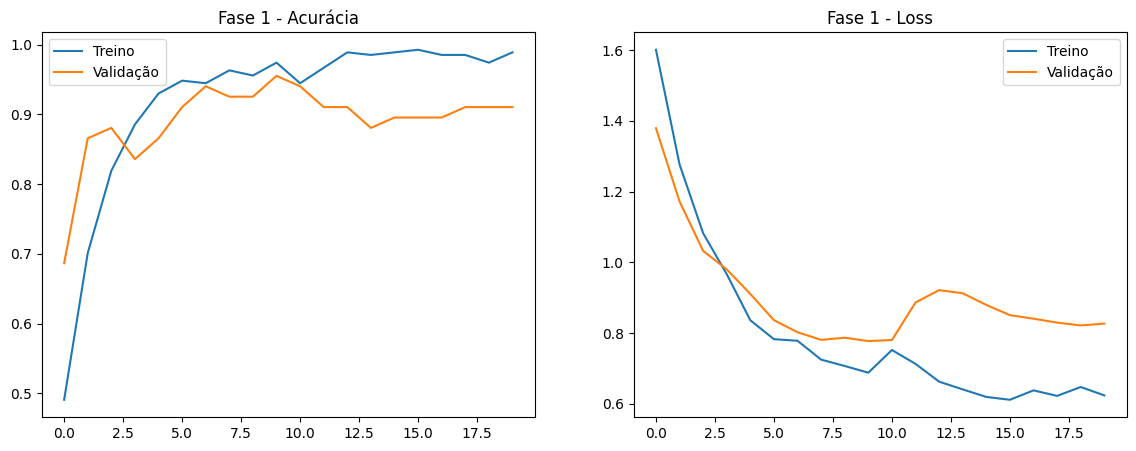

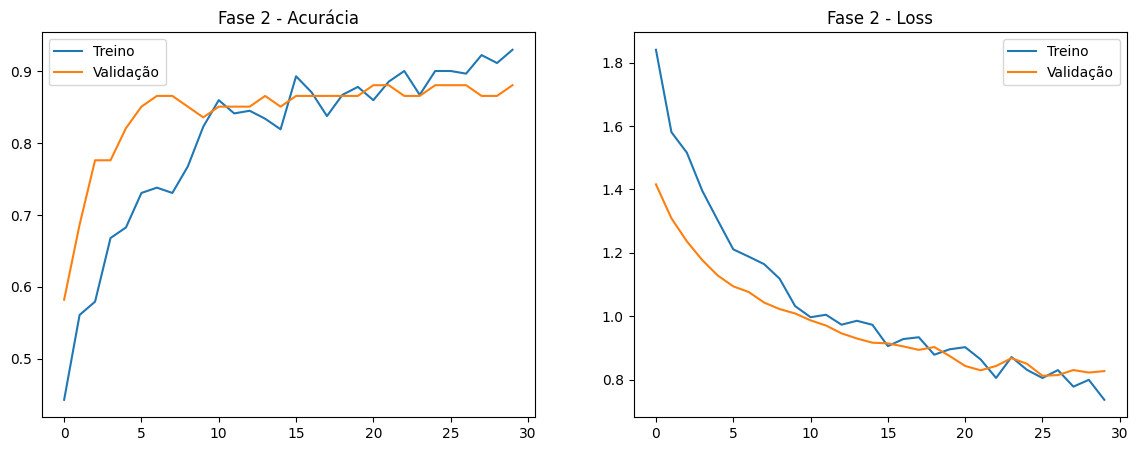

In [82]:
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    plt.plot(acc, label='Treino')
    plt.plot(val_acc, label='Validação')
    plt.title(f'{title} - Acurácia')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(loss, label='Treino')
    plt.plot(val_loss, label='Validação')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()

plot_history(history_fase1, 'Fase 1')
plot_history(history_fase2, 'Fase 2')


In [89]:
# Avaliação no conjunto de validação
val_loss, val_acc = model.evaluate(val_ds)
print("\n============================================================")
print("                  RESULTADOS DO MODELO")
print("============================================================\n")

print(f"Acurácia Final no Conjunto de Validação:")
print(f"   - Acurácia: {val_acc * 100:.1f}%\n")

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 697ms/step - accuracy: 0.8622 - loss: 0.8472

                  RESULTADOS DO MODELO

Acurácia Final no Conjunto de Validação:
   - Acurácia: 88.1%



In [68]:
model.save('modelo_coluna_final.keras')

from google.colab import files
files.download('modelo_coluna_final.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>